In [69]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
from dynamics_env.dynamics_rocket import Dynamics

In [70]:
seed=0
Myr_to_s = 86400 * 365 * 1e6
acc_to_SI = 1.504e-4
vel_to_SI = 4.744e2
start=None
rocket_mass=433100
destination_type='planet'
destination_params=None
capture_radius=6371e2
orbit_duration=50000
orbit_timesteps=250
dry_mass = rocket_mass * (1 - 0.9)
num_steps = int(orbit_timesteps)
v_e=3000e3
exp_name = 'rocket_venus'

thrusts = np.load(f'runs/{exp_name}_best_thrusts.npy')
best_orbit = np.load(f'runs/{exp_name}_best_orbit.npy')

def make_env(seed):
    def thunk():
        env = Dynamics(hyperparameters={
            'planetary_model_list':['point_source', 'planet', 'planet', 'planet'],
            'planetary_model_kwargs_list':[{'M':2e30, 'period':1e10, 'orbit_radius':0, 'phase':0}, # sun
                                            {'planet_name':'jupiter'}, # jupiter
                                            {'planet_name':'venus'},
                                            {'planet_name':'earth'}], # earth
            # 'planetary_model_kwargs_list':[{'M':2e30, 'period':1e10, 'orbit_radius':0, 'phase':0}, # sun
            #                                 {'M':1.898e27, 'period':11.86, 'orbit_radius':7.7866e11, 'phase':0.785}, # jupiter
            #                                 {'M':5.972e24, 'period':1, 'orbit_radius':1.496e11, 'phase':3.945}], # earth
            'seed':seed,
            'max_engine_thrust':7500e3,
        })
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk

env = make_env(seed=seed)()


episodic_reward = 0
if start == None:
    leo_distance = 6371e3 + 300e3 # 300e3 m
    leo_speed = 7.7e3 # 7.7e3 m/s
    earth_orbital_speed = 2.977e4 # m/s
    launch_theta = np.pi / 2 # np.random.rand() * 2 * np.pi * 0
    earth_pos = env.planetary_models[-1].get_position(0)
    launch_position = np.array([np.cos(launch_theta), np.sin(launch_theta)]) * leo_distance + earth_pos
    launch_velocity = np.array([np.cos(launch_theta), np.sin(launch_theta)]) * leo_speed + env.planetary_models[-1].get_velocity(0)
    launch_mass = np.array([rocket_mass])
    init_params = np.concat([launch_position, launch_velocity, launch_mass])
else: init_params = np.array(start)
if destination_type == 'radius':
    if destination_params == None:
        destination_radius = 35768e3 # geocentric orbit radius (easy)
        start_radius = 6371e3 + 300e3
    else:
        destination_radius = destination_params[0]
        start_radius = destination_params[1]
elif destination_type == 'planet':
    if destination_params == None:
        destination_planet_index = len(env.planetary_models)-2
        destination_planet_radius = 3396e3 # m (mars)
        destination_planet_radius = 6051.8e3 # m (venus)
    else:
        destination_planet_index = destination_params[0]
        destination_planet_radius = destination_params[1]
    start_planet_distance = np.linalg.norm(init_params[:2] - env.planetary_models[destination_planet_index].get_position(0))
elif destination_type == 'destination':
    if destination_params == None:
        earth_pos = env.planetary_models[-1].get_position(0)
        destination_coords = earth_pos * 0.99 # L1 point from earth center in m
        destination_radius = 2e7 # earth radius in m
    else:
        destination_coords = np.array([destination_params[0], destination_params[1]])
        destination_radius = destination_params[2]
    start_destination_distance = np.linalg.norm(init_params[:2] - destination_coords)

In [71]:
def reward_function(pos, prev_pos, mass, prev_mass, t):
    if destination_type == 'radius':
        earth_position = env.planetary_models[-1].get_position(t)
        current_radius = np.linalg.norm(pos - earth_position, axis=-1)
        prev_radius = np.linalg.norm(prev_pos - earth_position, axis=-1)
        consistent_reward = (current_radius - prev_radius) / (destination_radius - start_radius) + (mass - prev_mass) / rocket_mass
        completion_reward = current_radius >= destination_radius
    elif destination_type == 'planet':
        planet_position = env.planetary_models[destination_planet_index].get_position(t)
        current_distance_to_planet = np.linalg.norm(planet_position - pos, axis=-1)
        prev_distance_to_planet = np.linalg.norm(planet_position - prev_pos, axis=-1)
        consistent_reward = (current_distance_to_planet - prev_distance_to_planet) / start_planet_distance + (mass - prev_mass) / rocket_mass
        completion_reward = np.linalg.norm(pos - planet_position, axis=-1) < destination_planet_radius
    elif destination_type == 'destination':
        current_distance = np.linalg.norm(destination_coords - pos, axis=-1)
        prev_distance = np.linalg.norm(destination_coords - prev_pos, axis=-1)
        consistent_reward = (prev_distance - current_distance) / start_destination_distance + (mass - prev_mass) / rocket_mass
        completion_reward = current_distance < destination_radius
    return consistent_reward + completion_reward

def distance_to_dest_function(pos, t):
    if destination_type == 'radius':
        earth_position = env.planetary_models[-1].get_position(t)
        current_radius = np.linalg.norm(pos - earth_position, axis=-1)
        distance_to_dest = destination_radius - current_radius
    elif destination_type == 'destination_planet':
        planet_position = env.planetary_models[destination_planet_index].get_position(t)
        distance_to_dest = start_planet_distance - np.linalg.norm(planet_position - pos, axis=-1)
    elif destination_type == 'destination':
        current_distance = np.linalg.norm(destination_coords - pos, axis=-1)
        distance_to_dest = start_destination_distance - current_distance
    return distance_to_dest

def done_function(pos, t):
    if destination_type == 'radius':
        earth_position = env.planetary_models[-1].get_position(t)
        current_radius = np.linalg.norm(pos - earth_position)
        completion_reward = current_radius >= destination_radius
    elif destination_type == 'destination_planet':
        planet_position = env.planetary_models[destination_planet_index].get_position(t)
        completion_reward = np.linalg.norm(pos - planet_position) < destination_planet_radius
    elif destination_type == 'destination':
        completion_reward = np.linalg.norm(pos - destination_coords) < destination_radius
    return completion_reward

def event_dest_reached(t, y, thrust):
    pos = y[:2]
    if destination_type == 'radius':
        earth_position = env.planetary_models[-1].get_position(t)
        current_radius = np.linalg.norm(pos - earth_position)
        completion = 0 if current_radius >= destination_radius else 1
    elif destination_type == 'planet':
        planet_position = env.planetary_models[destination_planet_index].get_position(t)
        completion = 0 if np.linalg.norm(pos - planet_position) < destination_planet_radius else 1
    elif destination_type == 'destination':
        completion = 0 if np.linalg.norm(pos - destination_coords) < destination_radius else 1
    return completion
event_dest_reached.terminal = True

def event_rocket_captured(t, y, thrust):
    pos = y[:2]
    min_dist = np.inf
    for model in env.planetary_models:
        dist = np.linalg.norm(pos - model.get_position(t))
        min_dist = min(min_dist, dist)
    return min_dist - capture_radius
event_rocket_captured.terminal = True

def rocket_function(t, y, thrust):
    # state packaging
    pos = y[:2]
    vel = y[2:4]
    mass = y[-1:]
    a_gravity = env.get_acceleration(np.concat([pos, np.array([t])]))
    # rocket science
    mdot = -np.linalg.norm(thrust, axis=-1) / v_e # in m/s^2
    delta_m = mdot * orbit_duration / orbit_timesteps
    if (mass - delta_m) < dry_mass:
        a_thrust = np.zeros_like(thrust)
        mdot = 0
    else:
        a_thrust = thrust / mass
    # derivatives for integrator
    dydt = np.zeros_like(y)
    dydt[:2] = vel
    dydt[2:4] = a_gravity + a_thrust
    dydt[4] = mdot
    return dydt

def get_unit_vector_to_dest(pos):
    dest = destination_coords
    vector_to_dest = dest - pos
    unit_vector_to_dest = vector_to_dest / np.linalg.norm(vector_to_dest)
    return unit_vector_to_dest

In [72]:
delta_t = orbit_duration / orbit_timesteps
prev_logprob = None
done = False
# state = torch.tensor(init_params, dtype=torch.float32).to(device)

# observations = torch.zeros((num_steps,)+env.observation_space.shape, dtype=torch.float32).to(device)
# actions = torch.zeros((num_steps,)+env.action_space.shape, dtype=torch.float32).to(device)
# logprobs = torch.zeros((num_steps,)+env.action_space.shape, dtype=torch.float32).to(device)
# rewards = torch.zeros((num_steps,), dtype=torch.float32).to(device)
# dones = torch.zeros((num_steps,), dtype=torch.float32).to(device)
# values = torch.zeros((num_steps,), dtype=torch.float32).to(device)
clip_fracs = []
y0 = init_params
t = 0
trajectory = [init_params]
times = [t]
rewards = []
termination_status = 0
termination_y_events = None
for j in range(orbit_timesteps):
    # preparing args for solve_ivp
    pos, vel, mass = y0[:2], y0[2:4], y0[-1:]
    a_gravity = env.get_acceleration(np.concat([pos, np.array([t])]))
    # planet_info = []
    # for planet_model in env.planetary_models:
    #     planet_pos = planet_model.get_position(t)
    #     planet_vel = planet_model.get_velocity(t)
    #     planet_mass = np.array([planet_model.M])
    #     planet_info.append(np.concat([planet_pos, planet_vel, planet_mass]))
    # planet_info = np.concat(planet_info)
    # distance_to_dest = np.array([distance_to_dest_function(pos, t)])
    # state = env._normalise_state(np.concat([pos, vel, a_gravity, mass, planet_info, distance_to_dest]))
    # state = env._normalise_state(torch.tensor(np.concat([pos, vel, a_gravity, mass, planet_info, distance_to_dest]), dtype=torch.float32, device=device)).float()
    # with torch.no_grad():
    #     action_means, action_stds = actor(state)
    # value = critic(state).flatten()
    # dist = torch.distributions.Normal(action_means, action_stds)
    # unit_vector_to_dest = get_unit_vector_to_dest(pos)
    # action = unit_vector_to_dest
    # logprob = dist.log_prob(action)
    # thrust = env._process_actions(action) # in N (kg m/s^2)
    thrust = thrusts[j]
    # orbit step integration
    orbit = solve_ivp(rocket_function, t_span=(t, t + delta_t), y0=y0, t_eval=[t + delta_t], events=[event_rocket_captured, event_dest_reached], args=(thrust,))
    if orbit.status == 1: 
        if len(orbit.t_events[0]) != 0: 
            termination_status = 1
            termination_y_events = orbit.y_events[0][0]
            y0 = termination_y_events
        else: 
            termination_status = 2
            termination_y_events = orbit.y_events[1][0]
            y0 = termination_y_events
    # PPO
    # observations[j] = state
    # actions[j] = action
    # logprobs[j] = logprob
    # dones[j] = torch.tensor(done_function(pos), dtype=torch.float32).to(device)
    # reward = reward_function(orbit.y[:2,-1], pos, orbit.y[-1:,-1], mass)
    # rewards[j] = torch.tensor(reward, dtype=torch.float32, device=device)
    # values[j] = value
    # preparing for next orbit step integration
    else:
        y0 = orbit.y[:,-1]
    t = t + delta_t
    reward = reward_function(y0[:2], pos, y0[-1], mass, t)
    trajectory.append(y0)
    times.append(t)
    rewards.append(reward)
    if orbit.status == 1: 
        termination_t = orbit.t_events[0]
        termination_y = orbit.y_events
        break

In [73]:
orbit = np.array(trajectory).transpose()

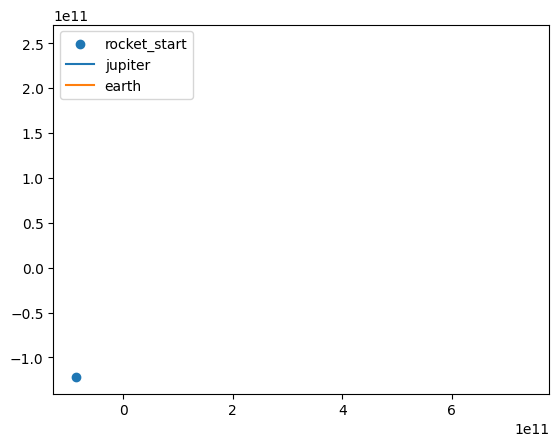

In [74]:
plot, axes = plt.subplots(1,1)
# axes.plot(orbit[0], orbit[1], label='rocket')
axes.scatter(orbit[0,0], orbit[1,0], label='rocket_start')
jupiter_orbit = env.planetary_models[1].get_position(t=np.linspace(13 * Myr_to_s / 1e6, orbit_timesteps))
axes.plot(jupiter_orbit[0], jupiter_orbit[1], label='jupiter')
earth_orbit = env.planetary_models[2].get_position(t=np.linspace(1 * Myr_to_s / 1e6, orbit_timesteps))
axes.plot(earth_orbit[0], earth_orbit[1], label='earth')
axes.legend()

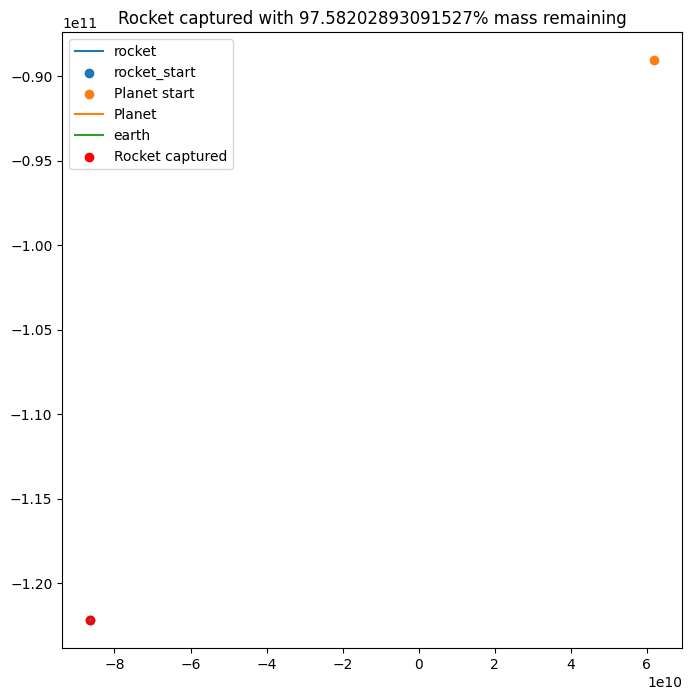

In [75]:
if destination_type == 'destination':
    plot, axes = plt.subplots(1,1)
    plot.set_size_inches(8,8)
    remaining_mass = orbit[-1,-1]
    axes.plot(orbit[0], orbit[1], label='rocket')
    axes.scatter(orbit[0,0], orbit[1,0], label='rocket_start')
    axes.scatter(destination_coords[0], destination_coords[1], label='L1 point')
    l1_x = np.linspace(-destination_radius,destination_radius,100)
    l1_y = np.sqrt(destination_radius**2 - l1_x**2)
    earth_orbit = env.planetary_models[2].get_position(t=np.linspace(0, orbit_duration, orbit_timesteps))
    axes.plot(l1_x + destination_coords[0], l1_y + destination_coords[1], label='L1 capture radius')
    axes.plot(l1_x + destination_coords[0], -l1_y + destination_coords[1], c='orange')
    axes.plot(earth_orbit[0], earth_orbit[1], label='earth')
    termination_message = 'Destination not reached'
    if termination_status:
        termination_message = 'Rocket captured' if termination_status == 1 else 'Destination reached'
        axes.scatter(termination_y_events[0], termination_y_events[1], label=termination_message, c='r')
    axes.set_title(f'{termination_message} with {remaining_mass/rocket_mass*100}% mass remaining')
    axes.legend()
elif destination_type == 'planet':
    plot, axes = plt.subplots(1,1)
    plot.set_size_inches(8,8)
    remaining_mass = orbit[-1,-1]
    axes.plot(orbit[0], orbit[1], label='rocket')
    axes.scatter(orbit[0,0], orbit[1,0], label='rocket_start')
    planet_pos = env.planetary_models[destination_planet_index].get_position(np.linspace(0, orbit_duration, orbit_timesteps))
    axes.scatter(planet_pos[0,0], planet_pos[1,0], label='Planet start')
    axes.plot(planet_pos[0], planet_pos[1], label='Planet')
    earth_orbit = env.planetary_models[2].get_position(t=np.linspace(0, orbit_duration, orbit_timesteps))
    axes.plot(earth_orbit[0], earth_orbit[1], label='earth')
    termination_message = 'Destination not reached'
    if termination_status:
        termination_message = 'Rocket captured' if termination_status == 1 else 'Destination reached'
        axes.scatter(termination_y_events[0], termination_y_events[1], label=termination_message, c='r')
    axes.set_title(f'{termination_message} with {remaining_mass/rocket_mass*100}% mass remaining')
    axes.legend()

/tmp/ipykernel_70118/1345953075.py:30: RuntimeWarning: invalid value encountered in sqrt
  earth_capture_y = np.sqrt(capture_radius**2 - (earth_capture_x - earth_capture_pos[0])**2)+earth_capture_pos[1]


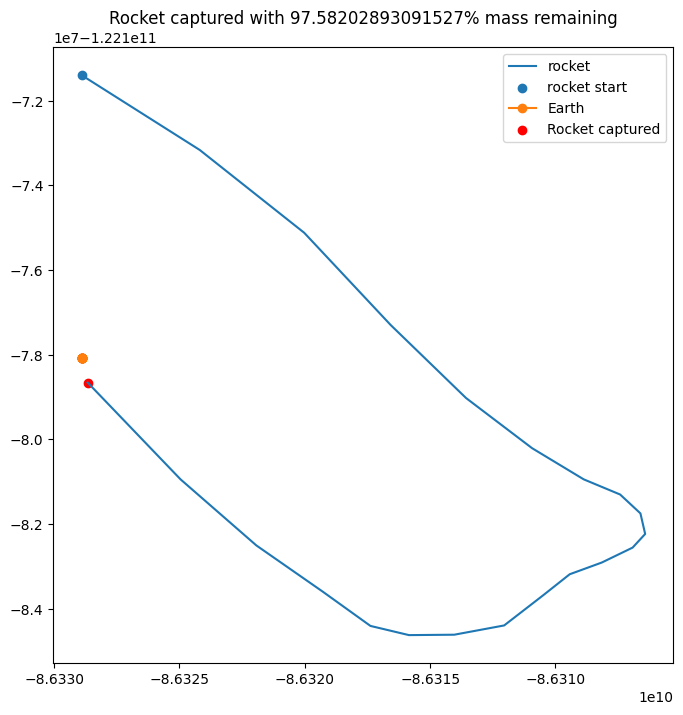

In [ ]:
if destination_type == 'destination':
    plot, axes = plt.subplots(1,1)
    plot.set_size_inches(8,8)
    remaining_mass = orbit[-1,-1]
    axes.plot(orbit[0], orbit[1], label='rocket')
    axes.scatter(orbit[0,0], orbit[1,0], label='rocket_start')
    axes.scatter(destination_coords[0], destination_coords[1], label='L1 point')
    l1_x = np.linspace(-destination_radius,destination_radius,100)
    l1_y = np.sqrt(destination_radius**2 - l1_x**2)
    earth_orbit = env.planetary_models[2].get_position(t=np.linspace(0, orbit_duration, orbit_timesteps))
    axes.plot(l1_x + destination_coords[0], l1_y + destination_coords[1], label='L1 capture radius')
    axes.plot(l1_x + destination_coords[0], -l1_y + destination_coords[1], c='orange')
    axes.plot(earth_orbit[0], earth_orbit[1], label='earth')
    termination_message = 'Destination not reached'
    if termination_status:
        termination_message = 'Rocket captured' if termination_status == 1 else 'Destination reached'
        axes.scatter(termination_y_events[0], termination_y_events[1], label=termination_message, c='r')
    axes.set_title(f'{termination_message} with {remaining_mass/rocket_mass*100}% mass remaining')
    axes.legend()
elif destination_type == 'planet':
    plot, axes = plt.subplots(1,1)
    plot.set_size_inches(8,8)
    remaining_mass = orbit[-1,-1]
    axes.plot(orbit[0], orbit[1], label='rocket')
    axes.scatter(orbit[0,0], orbit[1,0], label='rocket start')
    planet_pos = env.planetary_models[destination_planet_index].get_position(np.linspace(0, orbit_duration, orbit_timesteps))
    earth_orbit = env.planetary_models[-1].get_position(t=np.array(times))
    earth_capture_x = orbit[0]
    earth_capture_pos = env.planetary_models[-1].get_position(t=termination_t)
    earth_capture_y = np.sqrt(capture_radius**2 - (earth_capture_x - earth_capture_pos[0])**2)+earth_capture_pos[1]
    axes.plot(earth_orbit[0], earth_orbit[1], label='Earth', marker='o')
    termination_message = 'Destination not reached'
    if termination_status:
        termination_message = 'Rocket captured' if termination_status == 1 else 'Destination reached'
        axes.scatter(termination_y_events[0], termination_y_events[1], label=termination_message, c='r')
    axes.set_title(f'{termination_message} with {remaining_mass/rocket_mass*100}% mass remaining')
    axes.legend()

In [97]:
print(earth_orbit.shape)

(2, 22)


In [86]:
print(termination_pos/1e10)
print(orbit[0,0]/1e10, orbit[1,0]/1e10)
print(earth_orbit[0,0]/1e10, earth_orbit[1,0]/1e10)

[ -8.6328662  -12.21786571]
-8.632890436230786 -12.21713968829204
-8.632890436230786 -12.21780678829204


In [78]:
termination_time = termination_t[0]
termination_pos = termination_y[0][0][:2]

In [79]:
capture_dist = np.linalg.norm(orbit[:2,-1] - env.planetary_models[-1].get_position(termination_time), axis=-1)
print(capture_dist, capture_radius)
print(orbit[:2,-1])
print(env.planetary_models[-1].get_position(termination_time))

637099.9999943153 637100.0
[-8.63286620e+10 -1.22178657e+11]
[-8.63289044e+10 -1.22178068e+11]


In [81]:
earth_pos = env.planetary_models[-1].get_position(np.array(times))

-0.024170844966119997


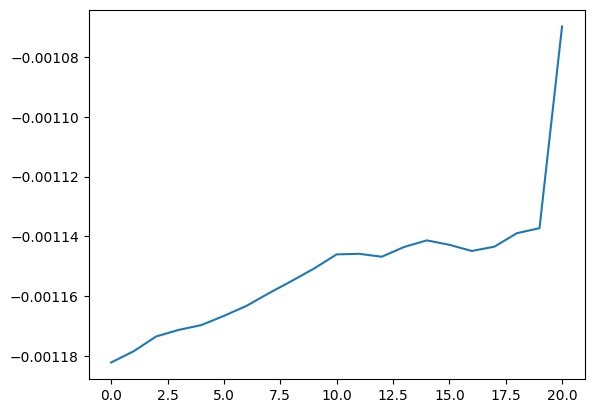

In [ ]:
plt.plot(rewards)
print(np.sum(rewards))

In [ ]:
"""
1.914984178634942 - l1
1.8545462690609582 - l1_easy
1.8881444795419724 - l1_expanded
"""

'\n1.914984178634942 - l1\n1.8545462690609582 - l1_easy\n1.8881444795419724 - l1_expanded\n'